# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Rémi Flamary

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["tp_newton", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

tp_newton_chen_bryan_and_devilder_alice.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, -grad_x, grad_x, c1=c1, c2=c2
        )
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


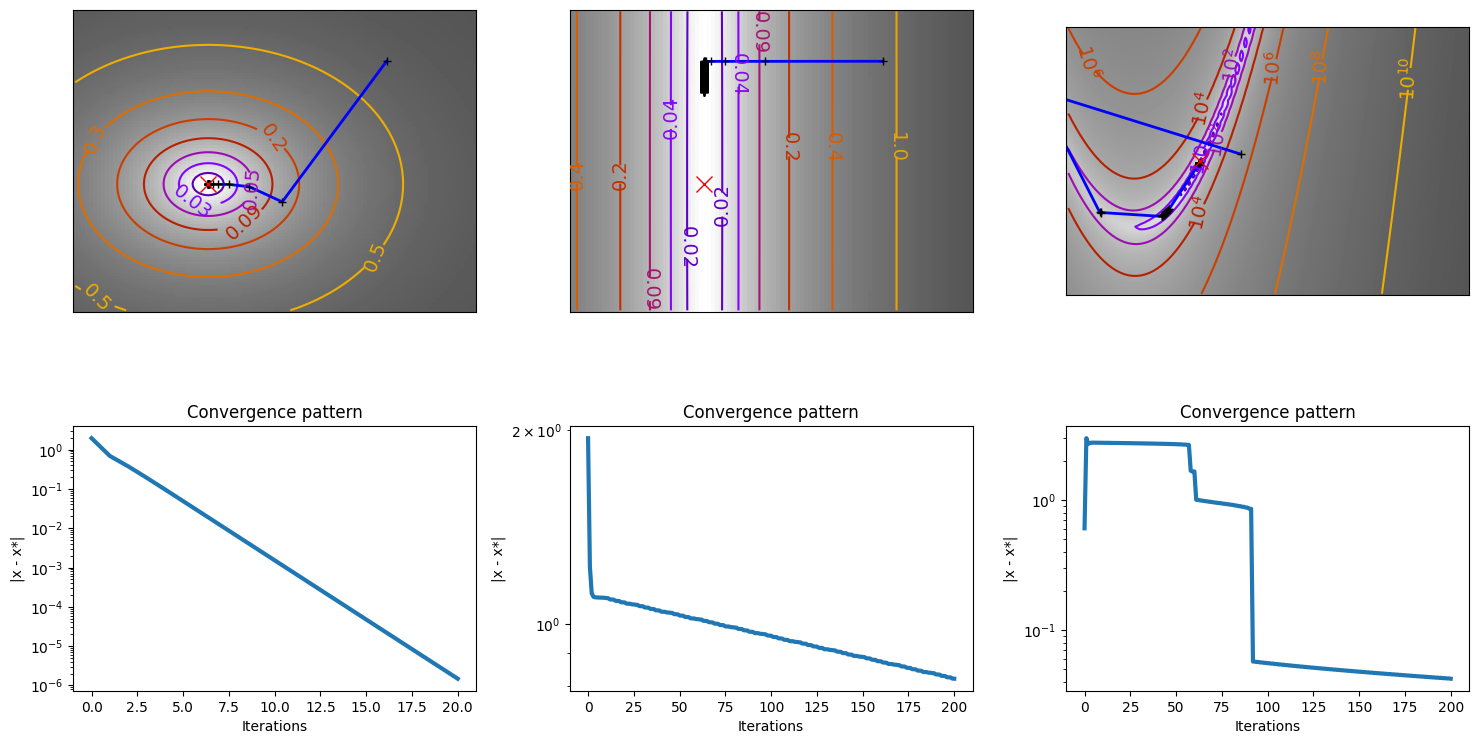

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [42]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001
    # lambda_threshold = 0.08  # regularization threshold

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute the Hessian, regularize it and compute the search direction d

        # TODO H = ..
        H = f_hessian(x)

        # compute the minimum of the eigenvalue of H
        min_eig = np.min(np.linalg.eigh(H)[0])
        if min_eig <= lambda_threshold:
            H_reg = H + (lambda_threshold - min_eig) * np.eye(H.shape[0])
        else:
            H_reg = H + lambda_threshold * np.eye(H.shape[0])

        d = - linalg.solve(H_reg, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        # If new_grad is None, we keep the one computed by line_search
        # if new_grad is None:
        #     new_grad = f_grad(x)

        # if new_f is None:
        #     new_f = f(x)

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


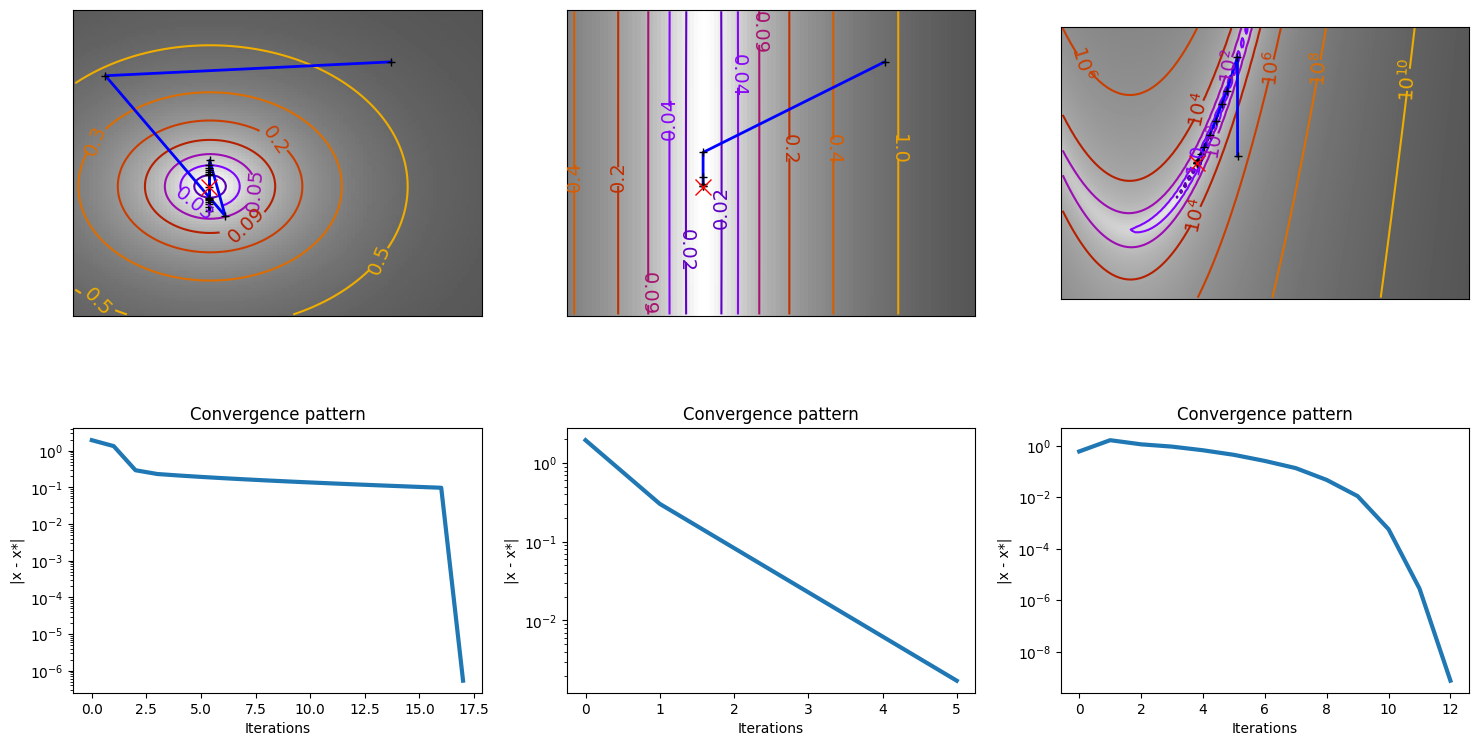

In [43]:
test_solver(newton)

**Comments**:

**1. Non-convex Gaussian kernel:** From what we have seen in class (slide 11), the Newton's direction may not be a descent direction for non-convex functions. This is what we observed at first without strong enough regularization (it was diverging). Therefore, in order to have a descent direction, we added a regularization term to the Hessian dynamically insofar as we added the difference between a small positive value (default regularization value) and the smallest eigenvalue of the Hessian. This way, we were able to observe a convergence to the minimum. The non-convex nature of the Gaussian kernel likely causes challenges for Newton's method therefore the convergence stagnates at a certain point and finally converges to the minimum.

**2. Badly conditioned quadratic function (but still strongly convex):** Newton's method is not affected by the conditioning of the Hessian for quadratic functions as mentionned in the slides. We also saw that the quadratic function should converge in one iteration with Newton's method. However, we observed that it converged in 5 iterations. This is likely due to the regularization we added to the Hessian.

**3. Rosenbrock function:** The Rosenbrock function is challenging for optimization due to its narrow, curved valley. The Newton's method can be attracted to saddle points. Thus, it struggles to align with the curvature at first, leading to slower initial progress. However, once sufficiently close to the optimum, quadratic convergence is observed, consistent with theoretical expectations.

<!-- WRITE YOUR COMMENTS HERE -->

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation

        # TODO B = ...
        B = B + np.outer(s, s) / np.dot(s, y) - np.outer(np.dot(B, y), np.dot(y, B)) / np.dot(y, np.dot(B, y))

        ################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


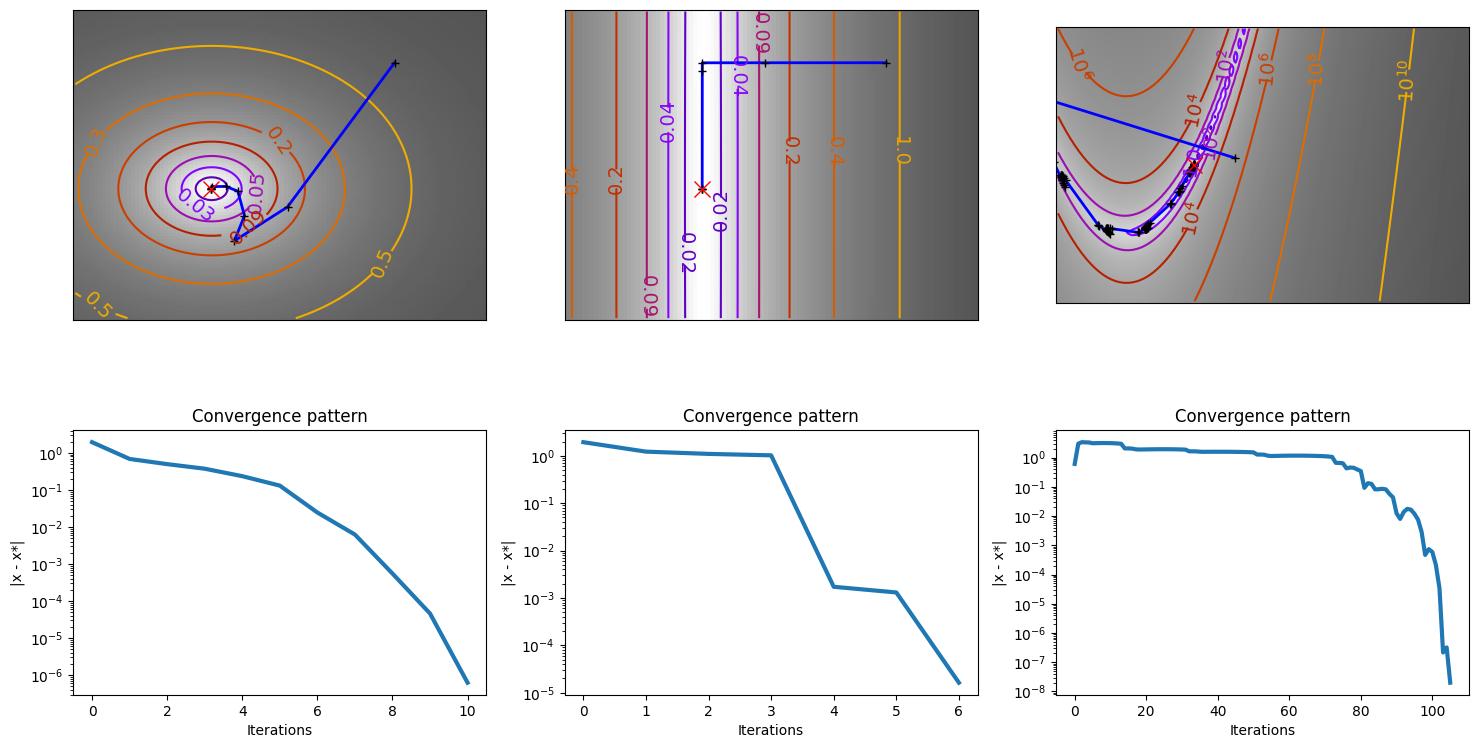

In [9]:
test_solver(dfp)

**Comments**: 

The DFP algorithm updates the inverse of the Hessian matrix using a rank-2 update while ensuring that it remains positive semi-definite. The algorithm iteratively refines the approximation of the inverse Hessian matrix to converge to the optimal solution.

**1. Non-convex Gaussian kernel:** The DFP algorithm achieves faster convergence than the Newton method for the non-convex function. Starting with a positive semi-definite inverse Hessian matrix and updating it iteratively led to better results in this scenario compared to directly using the Newton method. The DFP algorithm effectively captures the curvature of the non-convex Gaussian kernel, leading to faster convergence (this is the advantage Quasi-Newton methods have over Newton's method).

**2. Badly conditioned quadratic function (but still strongly convex):** According to theoretical results, the DFP algorithm should converge in \(p+1\) iterations for quadratic functions, where \(p\) is the dimension of the problem. However, in this case, the algorithm required 6 iterations to converge, even though \(p = 2\). This is a contradiction on the quadratic functions with what we've seen in class. This discrepancy arises because the step size is determined using a line search under Wolfe's conditions, which provides an approximation rather than the exact optimal step size.

**3. Rosenbrock function:** For the Rosenbrock function, the DFP algorithm required more than 100 iterations to converge, which is significantly slower compared to the Newton method.This slower performance can be attributed to the Rosenbrock function's challenging geometry: its global minimum lies within a long, narrow, parabolic-shaped valley. The Newton method succeeds because it directly computes the exact Hessian matrix, which allows it to align with the valley's curvature and find the optimal minimizing direction. In contrast, the DFP algorithm uses an approximation of the inverse Hessian, which may fail to capture the curvature of the Rosenbrock function effectively. Additionally, the convergence plot shows some bounds or irregularities.

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation

        # TODO B =
        mu = 1. / np.dot(y, s)
        B = (np.eye(len(x)) - mu * np.outer(s, y)) @ B @ (np.eye(len(x)) - mu * np.outer(y, s)) + mu * np.outer(s, s)

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


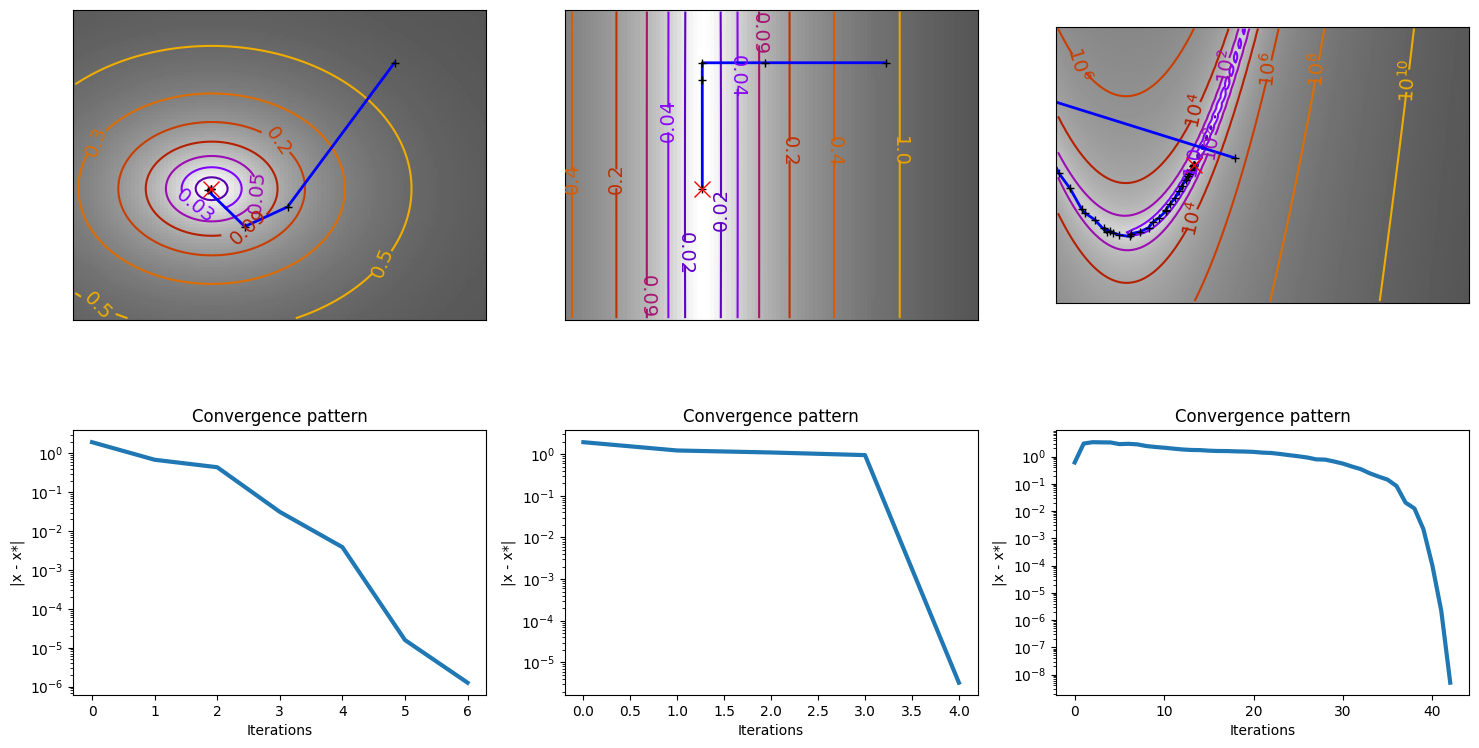

In [11]:
test_solver(bfgs)

**Comments**: We observe that BFGS is faster than DFP for the 3 functions. This is because the BFGS method has the same property as the DFP method but updates the inverse Hessian matrix using a rank-2 update while ensuring that it remains positive definite. Besides, BFGS is much less sensitive than DFP to the use of approximate step size therefore we have less irregularities (bounds) for the Rosenbrock function. 

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [12]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    for i in range(min(m, len(mu_list))-1, -1, -1):
        alpha = mu_list[i] * np.dot(s_list[i], q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(min(m, len(mu_list))):
        beta = mu_list[i] * np.dot(y_list[i], r)
        r += s_list[i] * (alpha_list[-i-1] - beta)
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        if new_f is None:
            new_f = f(x + step * d)

        if new_grad is None:
            new_grad = f_grad(x + step * d)
            
        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


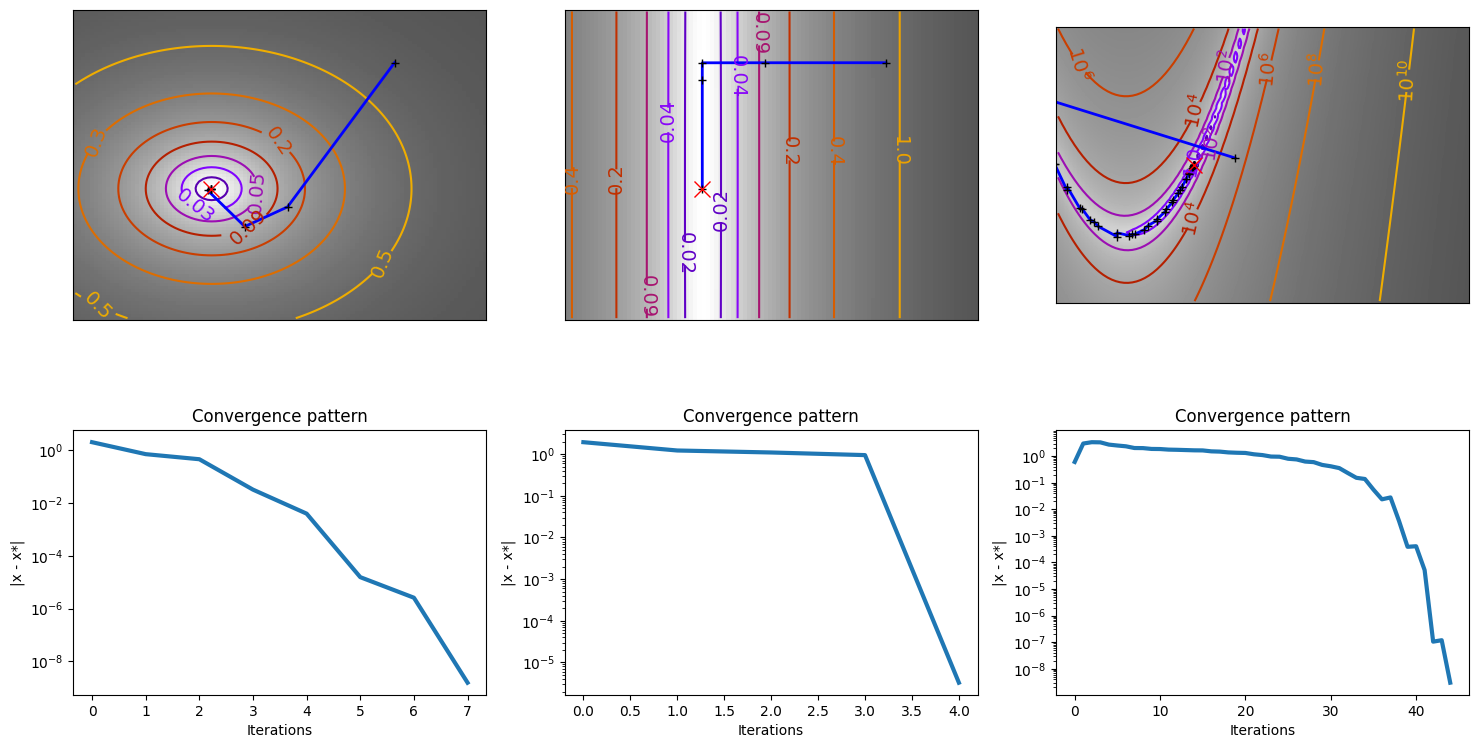

In [14]:
test_solver(lbfgs)

**Comments:** 

We observe similar results to the BFGS algorithm. The L-BFGS algorithm is a limited-memory version of the BFGS algorithm that approximates the inverse Hessian matrix using a limited number of vectors. The two-loop recursion is used to compute the search direction efficiently.

We could have better results with L-BFGS in the case where we work in bigger dimension (facing memory issues) with BFGS but in our case, p=2 so it's not really impactful. Therefore, we have similar results to BFGS.